### Imports

In [139]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,\
    GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,\
    FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,\
    GradientBoostingClassifier, AdaBoostClassifier,\
    BaggingClassifier, ExtraTreesClassifier,\
    VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

import xgboost

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem Description

My goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. Specifically, I'll be predicting two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.

### Data

In [3]:
submission_format = pd.read_csv('../Data/submission_format.csv')
submission_format.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   respondent_id     26708 non-null  int64  
 1   h1n1_vaccine      26708 non-null  float64
 2   seasonal_vaccine  26708 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 626.1 KB


The submission_format.csv is an example of how my submission should be submitted.

In [4]:
test_set_features = pd.read_csv('../Data/test_set_features.csv')
test_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26623 non-null  float64
 2   h1n1_knowledge               26586 non-null  float64
 3   behavioral_antiviral_meds    26629 non-null  float64
 4   behavioral_avoidance         26495 non-null  float64
 5   behavioral_face_mask         26689 non-null  float64
 6   behavioral_wash_hands        26668 non-null  float64
 7   behavioral_large_gatherings  26636 non-null  float64
 8   behavioral_outside_home      26626 non-null  float64
 9   behavioral_touch_face        26580 non-null  float64
 10  doctor_recc_h1n1             24548 non-null  float64
 11  doctor_recc_seasonal         24548 non-null  float64
 12  chronic_med_condition        25776 non-null  float64
 13  child_under_6_mo

The test_set_features.csv will be used to run my model and produce a predictive csv in the format of submission_format. 

In [5]:
training_set_features = pd.read_csv('../Data/training_set_features.csv')
training_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [6]:
training_set_labels = pd.read_csv('../Data/training_set_labels.csv')
training_set_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


The training_set_features and is the dataset used to predict the actual training_set_labels. They are already split, however I will be rejoining for any cleaning I find necessary and splitting again in a format that is more convenient since there is two target variables. 

In [7]:
complete_data = pd.merge(training_set_features, training_set_labels, on='respondent_id')

In [8]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [9]:
complete_data.isna().sum().sort_values(ascending=False)

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_adults                 249
household_children               249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowledge                   116
h1n1_concern                      92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

### Split

In [10]:
X = complete_data.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y1 = complete_data.filter(['h1n1_vaccine'])
y2 = complete_data.filter(['seasonal_vaccine'])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.33, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.33, random_state=42)

In [11]:
y_train1.value_counts()

h1n1_vaccine
0               14087
1                3806
dtype: int64

In [12]:
y_train2.value_counts()

seasonal_vaccine
0                   9502
1                   8391
dtype: int64

#### Using `Pipeline` and `FunctionTransformer`

In [13]:
# def grab_numeric(df):
#     return df.select_dtypes(include=['float', 'int'])

In [14]:
# The FunctionTransformer will turn my function
# into a transformer.
# GrabNumeric = FunctionTransformer(grab_numeric)

In [15]:
# # Pipe!

# pipe = Pipeline(steps=[
#     ('num', GrabNumeric),
#     ('ss', StandardScaler())
# ])

#### Using `Pipeline` and `ColumnTransformer`

In [16]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [17]:
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))])


subpipe_ord = Pipeline(steps=[('ord_impute', SimpleImputer(strategy='most_frequent')),
                              ('ord', OrdinalEncoder())])

In [18]:
cat_cols = []
ord_cols = []

In [19]:
for col in X.columns:
    if len(X[col].value_counts().index) > 2:
        cat_cols.append(col)
    else:
        ord_cols.append(col)

In [20]:
ord_cols

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'sex',
 'marital_status',
 'rent_or_own']

In [21]:
cat_cols

['h1n1_concern',
 'h1n1_knowledge',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_industry',
 'employment_occupation']

In [22]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.
ct = ColumnTransformer(transformers = [
    ('subpipe_cat', subpipe_cat, cat_cols),
    ('subpipe_ord', subpipe_ord, ord_cols)
])

In [95]:
pd.DataFrame(ct.fit_transform(X_train1))

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
count,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,...,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000
mean,0.307327,0.398145,0.173196,0.551724,0.355334,0.069077,0.175208,0.455038,0.267032,0.385626,...,0.675124,0.203487,0.306041,0.275136,0.079528,0.109484,0.936064,0.404348,0.437210,0.220198
std,0.461399,0.489529,0.378427,0.497331,0.478628,0.253593,0.380156,0.497988,0.442421,0.486756,...,0.468341,0.402603,0.460860,0.446595,0.270569,0.312254,0.244645,0.490779,0.496056,0.414392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Logistic Regression Pipeline

In [24]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.


logreg_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

In [25]:
y_train1 = y_train1.values.ravel()

In [26]:
logreg_model_pipe.fit(X_train1, y_train1);

In [27]:
logreg_model_pipe.score(X_train1, y_train1)

0.8396579668026602

In [28]:
cross_val_score(logreg_model_pipe, X_train1, y_train1)

array([0.83459067, 0.8393406 , 0.83654652, 0.8373393 , 0.83510341])

In [29]:
y_train2 = y_train2.values.ravel()

In [30]:
logreg_model_pipe.fit(X_train2, y_train2);

In [31]:
logreg_model_pipe.score(X_train2, y_train2)

0.7836025261275359

In [32]:
cross_val_score(logreg_model_pipe, X_train2, y_train2)

array([0.77312098, 0.78234144, 0.76725342, 0.78256009, 0.78731135])

#### Bringing in Our Modeling Class from before

In [33]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [34]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train1, y=y_train1)

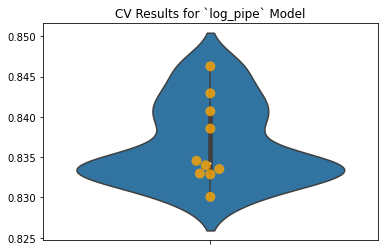

In [35]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax);

In [36]:
log_pipe.print_cv_summary()

CV Results for `log_pipe` model:
            0.83664 ± 0.00495 accuracy
        


In [80]:
logreg_model_pipe.fit(X_train1, y_train1)
y_hat = logreg_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.43 

Our final model's precision on the test set is 0.69 

Our final model's f1-score on the test is 0.53.



#### Nearest Neighbors Pipeline

In [96]:
pd.DataFrame(ct.fit_transform(X_train1)).describe()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
count,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,...,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000
mean,0.307327,0.398145,0.173196,0.551724,0.355334,0.069077,0.175208,0.455038,0.267032,0.385626,...,0.675124,0.203487,0.306041,0.275136,0.079528,0.109484,0.936064,0.404348,0.437210,0.220198
std,0.461399,0.489529,0.378427,0.497331,0.478628,0.253593,0.380156,0.497988,0.442421,0.486756,...,0.468341,0.402603,0.460860,0.446595,0.270569,0.312254,0.244645,0.490779,0.496056,0.414392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [97]:
knn = KNeighborsClassifier()
knn_model_pipe = Pipeline([('ct', ct), ('knn', knn)]) 
#Need StandardScaler? No features are numeric

In [98]:
knn_model_pipe.fit(X_train1, y_train1);

In [99]:
knn_pipe = ModelWithCV(knn_model_pipe, 'knn_pipe', X_train1, y_train1)

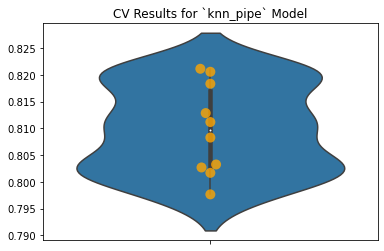

In [100]:
fig, ax = plt.subplots()

knn_pipe.plot_cv(ax=ax);

In [101]:
knn_pipe.print_cv_summary()

CV Results for `knn_pipe` model:
            0.80976 ± 0.00799 accuracy
        


In [102]:
knn_model_pipe.fit(X_train1, y_train1)
y_hat = knn_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.81. 

Our final model's recall on the test set is 0.33 

Our final model's precision on the test set is 0.57 

Our final model's f1-score on the test is 0.42.



#### Random Forest Pipeline

In [37]:
# rfc!
rfc = RandomForestClassifier(random_state=42)
rfc_model_pipe = Pipeline([('ct', ct), ('rfc', rfc)])

In [38]:
rfc_model_pipe.fit(X_train1, y_train1);

In [39]:
forest_pipe = ModelWithCV(rfc_model_pipe, 'forest_pipe', X_train1, y_train1)

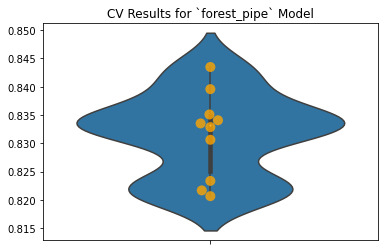

In [40]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [41]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.83150 ± 0.00718 accuracy
        


In [79]:
rfc_model_pipe.fit(X_train1, y_train1)
y_hat = rfc_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.35 

Our final model's precision on the test set is 0.7 

Our final model's f1-score on the test is 0.47.



#### Gradient Booster

In [42]:
# gbc!
gbc_model_pipe = Pipeline([('ct', ct), ('gbc', GradientBoostingClassifier(random_state=42))])

In [43]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train1,
                         y=y_train1)

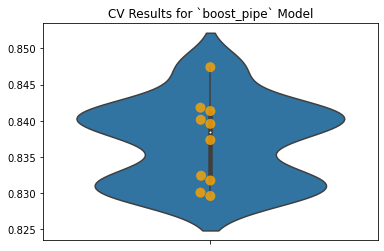

In [44]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax);

In [45]:
boost_pipe.print_cv_summary()

CV Results for `boost_pipe` model:
            0.83714 ± 0.00564 accuracy
        


In [78]:
gbc_model_pipe.fit(X_train1, y_train1)
y_hat = gbc_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.41 

Our final model's precision on the test set is 0.69 

Our final model's f1-score on the test is 0.52.



#### AdaBoost 

In [56]:
ada = AdaBoostClassifier()
ada_model_pipe = Pipeline([('ct', ct), ('ada', ada)])

In [57]:
ada_pipe = ModelWithCV(model=ada_model_pipe,
                         model_name='ada_pipe',
                         X=X_train1,
                         y=y_train1)

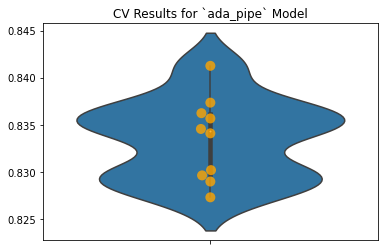

In [60]:
fig, ax = plt.subplots()

ada_pipe.plot_cv(ax=ax);

In [61]:
ada_pipe.print_cv_summary()

CV Results for `ada_pipe` model:
            0.83351 ± 0.00417 accuracy
        


In [77]:
ada_model_pipe.fit(X_train1, y_train1)
y_hat = ada_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.42 

Our final model's precision on the test set is 0.69 

Our final model's f1-score on the test is 0.52.



#### XGBoost 

In [103]:
xgb = xgboost.XGBClassifier(random_state=42)
xgb_model_pipe = Pipeline([('ct', ct), ('xgb', xgb)])

In [70]:
xgb_pipe = ModelWithCV(model=xgb_model_pipe,
                         model_name='xgb_pipe',
                         X=X_train1,
                         y=y_train1)

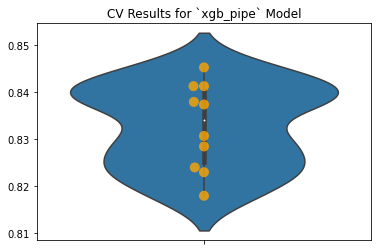

In [71]:
fig, ax = plt.subplots()

xgb_pipe.plot_cv(ax=ax);

In [72]:
xgb_pipe.print_cv_summary()

CV Results for `xgb_pipe` model:
            0.83267 ± 0.00876 accuracy
        


In [76]:
xgb_model_pipe.fit(X_train1, y_train1)
y_hat = xgb_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.46 

Our final model's precision on the test set is 0.66 

Our final model's f1-score on the test is 0.54.



#### Extra Trees Classifier

In [128]:
etc = ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42)
etc_model_pipe = Pipeline([('ct', ct), ('etc', etc)])

In [129]:
etc_pipe = ModelWithCV(model=etc_model_pipe,
                         model_name='etc_pipe',
                         X=X_train1,
                         y=y_train1)

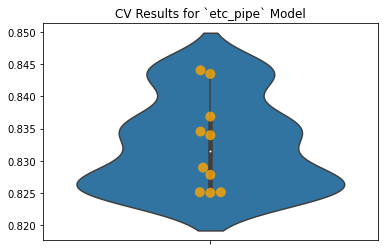

In [130]:
fig, ax = plt.subplots()

etc_pipe.plot_cv(ax=ax);

In [131]:
etc_pipe.print_cv_summary()

CV Results for `etc_pipe` model:
            0.83250 ± 0.00691 accuracy
        


In [132]:
etc_model_pipe.fit(X_train1, y_train1)
y_hat = etc_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.33 

Our final model's precision on the test set is 0.71 

Our final model's f1-score on the test is 0.45.



#### Bagging

In [ ]:
bag = BaggingClassifier(n_estimators=100, random_state=42)
bag_model_pipe = Pipeline([('ct', ct), ('bag', bag)])

In [ ]:
bag_pipe = ModelWithCV(model=bag_model_pipe,
                         model_name='bag_pipe',
                         X=X_train1,
                         y=y_train1)

In [ ]:
fig, ax = plt.subplots()

bag_pipe.plot_cv(ax=ax);

In [ ]:
bag_pipe.print_cv_summary()

In [ ]:
bag_model_pipe.fit(X_train1, y_train1)
y_hat = bag_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")

### Ensembles

#### Voting Classifier

In [106]:
avg1 = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=1000)),
    ('knn', knn),
    ('rfc', rfc)    
])
avg1_model_pipe = Pipeline([('ct', ct), ('avg1', avg1)])

In [107]:
avg1_pipe = ModelWithCV(model=avg1_model_pipe,
                         model_name='avg1_pipe',
                         X=X_train1,
                         y=y_train1)

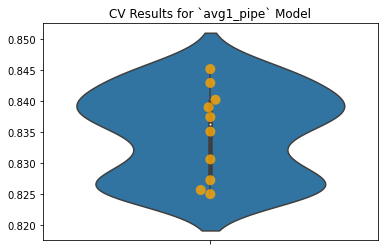

In [108]:
fig, ax = plt.subplots()

avg1_pipe.plot_cv(ax=ax);

In [109]:
avg1_pipe.print_cv_summary()

CV Results for `avg1_pipe` model:
            0.83485 ± 0.00693 accuracy
        


In [110]:
avg1_model_pipe.fit(X_train1, y_train1)
y_hat = avg1_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.36 

Our final model's precision on the test set is 0.7 

Our final model's f1-score on the test is 0.48.



In [111]:
avg2 = VotingClassifier(estimators=[
    ('gbc', GradientBoostingClassifier(random_state=42)),
    ('ada', ada),
    ('xgb', xgb)    
])
avg2_model_pipe = Pipeline([('ct', ct), ('avg2', avg2)])

In [112]:
avg2_pipe = ModelWithCV(model=avg2_model_pipe,
                         model_name='avg2_pipe',
                         X=X_train1,
                         y=y_train1)

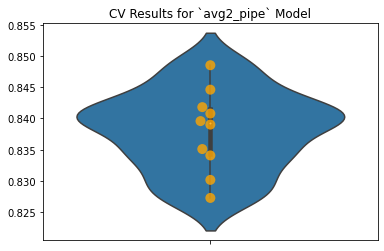

In [113]:
fig, ax = plt.subplots()

avg2_pipe.plot_cv(ax=ax);

In [114]:
avg2_pipe.print_cv_summary()

CV Results for `avg2_pipe` model:
            0.83809 ± 0.00616 accuracy
        


In [115]:
avg2_model_pipe.fit(X_train1, y_train1)
y_hat = avg2_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.42 

Our final model's precision on the test set is 0.69 

Our final model's f1-score on the test is 0.53.



In [118]:
avg3 = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=1000)),
    ('knn', knn),
    ('rfc', rfc),
    ('gbc', GradientBoostingClassifier(random_state=42)),
    ('ada', ada),
    ('xgb', xgb)
])
avg3_model_pipe = Pipeline([('ct', ct), ('avg3', avg3)])

In [119]:
avg3_pipe = ModelWithCV(model=avg3_model_pipe,
                         model_name='avg3_pipe',
                         X=X_train1,
                         y=y_train1)

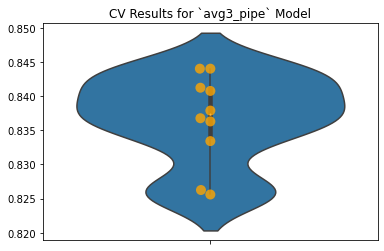

In [120]:
fig, ax = plt.subplots()

avg3_pipe.plot_cv(ax=ax);

In [121]:
avg3_pipe.print_cv_summary()

CV Results for `avg3_pipe` model:
            0.83664 ± 0.00624 accuracy
        


In [122]:
avg3_model_pipe.fit(X_train1, y_train1)
y_hat = avg3_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.38 

Our final model's precision on the test set is 0.73 

Our final model's f1-score on the test is 0.5.



#### Weighted Voting Classifier

#### Stacking

In [133]:
estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=1000)),
    ('knn', knn),
    ('rfc', rfc)    
]

In [140]:
sr = StackingClassifier(estimators)
sr_model_pipe = Pipeline([('ct', ct), ('sr', sr)])

In [141]:
sr_pipe = ModelWithCV(model=sr_model_pipe,
                         model_name='sr_pipe',
                         X=X_train1,
                         y=y_train1)

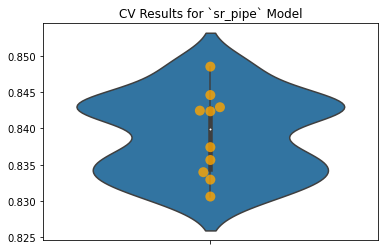

In [142]:
fig, ax = plt.subplots()

sr_pipe.plot_cv(ax=ax);

In [143]:
sr_pipe.print_cv_summary()

CV Results for `sr_pipe` model:
            0.83916 ± 0.00553 accuracy
        


In [144]:
sr_model_pipe.fit(X_train1, y_train1)
y_hat = sr_model_pipe.predict(X_test1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.42 

Our final model's precision on the test set is 0.69 

Our final model's f1-score on the test is 0.52.



### Tuning and Cross-Validating

In [46]:
#Gridsearch
params = {}

params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [1,5,10]

In [47]:
gs = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10)

In [48]:
gs.fit(X_train1, y_train1);

In [49]:
gs.cv_results_['mean_test_score']

array([0.8314987 , 0.83043743, 0.82943075, 0.83144327, 0.83194613,
       0.82937517])

In [50]:
gs.best_params_

{'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 5}

### Evaluation on Test Set

In [51]:
final_model = rfc_model_pipe

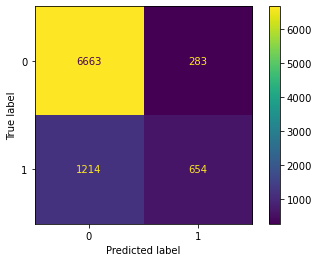

In [52]:
plot_confusion_matrix(final_model, X_test1, y_test1);

In [53]:
y_hat = final_model.predict(X_test1)

In [54]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.35 

Our final model's precision on the test set is 0.7 

Our final model's f1-score on the test is 0.47.

